In [1]:
# Python 3 Enviornment
# Importing our necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
import os

print(os.listdir(r"Data"))

['.ipynb_checkpoints', 'BBC News Sample Solution.csv', 'BBC News Test.csv', 'BBC News Train.csv']


In [2]:
# Looking at our data
Trainpath = os.path.join("Data/BBC News Train.csv")

# Load our data
Traindata = pd.read_csv(Trainpath)

# Read our data to review columns, and datapoints
Traindata.head()

# We need to encode our data then save it to a new column
Traindata['category_id'] = Traindata['Category'].factorize()[0]

# Review our dataframe
Traindata.head(10)

# Lets look at our categories and corresponding ID numbers
category_id = Traindata[['Category', 'category_id']].drop_duplicates().sort_values('category_id')

# drop index and review
category_id.reset_index(drop=True, inplace=True)

# index matches our cateogory_id
category_id

,Category,category_id
0,business,0
1,tech,1
2,politics,2
3,sport,3
4,entertainment,4


In [3]:
# Create a dictionary that can convert category names into category_id
category_to_id = dict(category_id.values)

# inverse the dict
id_to_category = {v: i for i, v in category_to_id.items()}

<AxesSubplot:xlabel='Category'>

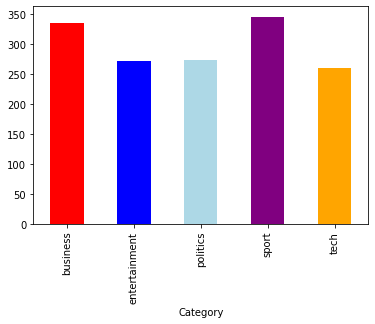

In [4]:
# Sample our data
Traindata.sample(10)

# Count and view our data
Traindata.groupby('Category').category_id.count()

# Bar plot for visualization 
Traindata.groupby('Category').category_id.count().plot.bar(ylim=0,
                                                           color=['red','blue','lightblue',
                                                                 'purple','orange'])

In [5]:
# Bring in our Tfid Vectorizer
    # Sublinear_tf set to True to give returns as freq. of word decreases
    # Min_df is minimum number of documents a word must be present in to be kept
    # norm is to ensure all our feature vectors have a euclidian norm of 1
    # encoding is used by our input text
    # ngram_range to indicate that we want to consider single words ('money', 'business') amd pairs of words ('stock market', 'comedy movies')
    # stop_words set to english for removing all common pronouns ('a', 'he', 'it')
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', encoding='latin-1', 
                        ngram_range=(1,2), stop_words='english')

features = tfidf.fit_transform(Traindata.Text).toarray()
# turns our texts into features 

# Assign our labels
labels = Traindata.category_id
labels

0       0
1       0
2       0
3       1
4       0
       ..
1485    4
1486    4
1487    0
1488    1
1489    1
Name: category_id, Length: 1490, dtype: int64

In [6]:
# Check our feauture shapes. How many features are there?
print(features.shape)

sorted(category_to_id.items())

(1490, 4782)


[('business', 0),
 ('entertainment', 4),
 ('politics', 2),
 ('sport', 3),
 ('tech', 1)]

In [41]:
from sklearn.feature_selection import chi2

N = 5 # Looking at the top five words foe each category

# For each category find words that are highly correlated with it
# Gets the category and id from sorted list
for Category, category_id in sorted(category_to_id.items()):
    # Do chi2 analysis of all items in this category
    features_chi2 = chi2(features, labels == category_id)
    # Sorts the indicies of features_chi2
    indicies = np.argsort(features_chi2[0])
    # Converts indicies to feature names (increasing chi2 order)
    feature_names = np.array(tfidf.get_feature_names())[indicies]
    # List of single word features (in increasing order of chi2 stat values)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    # List for two-words (in increasing order of chi2 stat values)
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    
    print("# '{}':".format(Category))
    
    # Prints 5 unigrams with highest chi squared stat
    print(" . Most Correlated unigrams:\n    .{}".format('\n    .'.join(unigrams[-N:])))
    # Prints 5 bigrams with highest chi squared stat
    print(" . Most Correlated bigrams:\n    .{}".format('\n    .'.join(bigrams[-N:])))
    

# 'business':
 . Most Correlated unigrams:
    .economy
    .oil
    .growth
    .bank
    .shares
 . Most Correlated bigrams:
    .chief executive
    .oil prices
    .stock market
    .economic growth
    .analysts said
# 'entertainment':
 . Most Correlated unigrams:
    .awards
    .album
    .singer
    .actor
    .film
 . Most Correlated bigrams:
    .film festival
    .won best
    .best film
    .los angeles
    .box office
# 'politics':
 . Most Correlated unigrams:
    .tories
    .party
    .blair
    .election
    .labour
 . Most Correlated bigrams:
    .mr brown
    .general election
    .prime minister
    .tony blair
    .mr blair
# 'sport':
 . Most Correlated unigrams:
    .season
    .injury
    .coach
    .match
    .cup
 . Most Correlated bigrams:
    .year old
    .world cup
    .grand slam
    .champions league
    .australian open
# 'tech':
 . Most Correlated unigrams:
    .microsoft
    .computer
    .technology
    .software
    .users
 . Most Correlated bigrams:


In [42]:
features_chi2

(array([0.15673482, 0.36024914, 0.61091723, ..., 0.71520008, 0.03542925,
        0.00574587]),
 array([0.69218066, 0.5483679 , 0.43444266, ..., 0.3977229 , 0.85069904,
        0.939577  ]))

In [43]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationaly expensive
# Gets the length down to 30%
Samp_size = int(len(features) * 0.3)
np.random.seed(0)

# Randomly selects 30% of samples
indicies = np.random.choice(range(len(features)), size=Samp_size, replace=False)

# Array of all projected features of 30% of Randomly chosen samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indicies])

In [44]:
my_id = 0 # selects category_id

projected_features[(labels[indicies] == my_id).values]


array([[ -7.038503  ,  -4.14367   ],
       [-19.748566  ,  -9.95068   ],
       [ -6.1492243 , -16.122793  ],
       [ -1.2916738 , -10.573231  ],
       [ 13.2152405 ,  24.128468  ],
       [ -4.360479  , -10.647816  ],
       [-23.667856  ,  -1.6449893 ],
       [ -5.9305325 ,  -9.685599  ],
       [-16.936007  , -18.673864  ],
       [-10.032745  , -17.645622  ],
       [ -7.458876  ,  19.998806  ],
       [-10.013162  , -12.671203  ],
       [-19.900597  , -16.374363  ],
       [-16.054462  ,  -9.854694  ],
       [  1.1867887 , -10.946933  ],
       [ -8.533413  , -12.016898  ],
       [-19.37486   , -10.951462  ],
       [ -4.3443885 ,  -8.687464  ],
       [-12.128221  ,  -6.2662225 ],
       [-22.584747  ,  -4.33655   ],
       [ -7.7641163 , -23.668333  ],
       [-15.252922  ,  -3.1900856 ],
       [ -7.2909503 , -14.940962  ],
       [-16.510393  ,  -3.6949914 ],
       [ -7.3642364 ,  -8.158136  ],
       [-19.074492  ,  -5.4731054 ],
       [-14.54014   ,  -5.2991223 ],
 

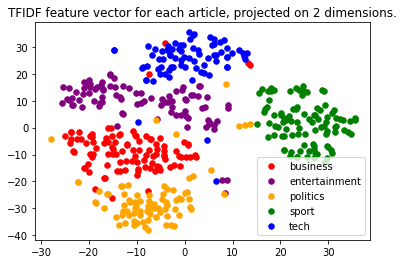

In [45]:
colors = ['red','blue','orange','green','purple']

# Finds points associated with categories and plots them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indicies] == category_id).values]
    plt.scatter(points[:, 0], points[:,1],s=30,c=colors[category_id], label=category)
plt.title('TFIDF feature vector for each article, projected on 2 dimensions.')
plt.legend()
plt.show()

In [46]:
category_id

1

In [47]:
# Import our lin models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# insitialize our models and set params
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [48]:
# Cross validation time BABBBYYYYY
CV = 10

# Creates dataframe that will store the results for all 5 trials of the 3 different models
cv_storage = pd.DataFrame(index=range(CV * len(models)))

# At start all entries are empty
entries = []

In [49]:
# Here we run EACH algorithm 10 times and store accuracy results in "entries"
for model in models:
    model_name = model.__class__.__name__
    
    # Create 5 models with different 20% test sets, and store their accuracy
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    
    # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 15 entries 
    # (3 models * 5 cross validations))
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

In [50]:
# Store the new entries into the results dataframe and name its columns
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [51]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.812081
1,RandomForestClassifier,1,0.852349
2,RandomForestClassifier,2,0.852349
3,RandomForestClassifier,3,0.838926
4,RandomForestClassifier,4,0.825503
5,RandomForestClassifier,5,0.845638
6,RandomForestClassifier,6,0.872483
7,RandomForestClassifier,7,0.872483
8,RandomForestClassifier,8,0.832215
9,RandomForestClassifier,9,0.852349


model_name
LogisticRegression        0.973154
MultinomialNB             0.971141
RandomForestClassifier    0.845638
Name: accuracy, dtype: float64

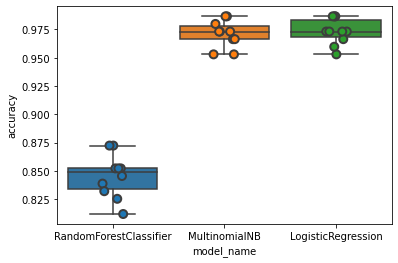

In [52]:
# Visualizing accuracy
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, linewidth=2)

# Group our accuracy scores
cv_df.groupby('model_name').accuracy.mean()

In [53]:
# Logistic Regression does the best so we are going to test it with 33% randomly chosen data
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

# Split our data 
X_train, X_test, y_train, y_test, indicies_train, indicies_test = train_test_split(features, labels,
                                                                                  Traindata.index, test_size=0.33,
                                                                                  random_state=0)

# Fit / "train" our algorithm
model.fit(X_train, y_train)

# Make predictions
y_pred_probability = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [54]:
category_id

1

Text(0.5, 15.0, 'Predicted')

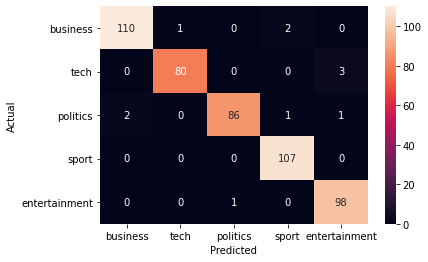

In [55]:
# Reinitialize our dataframe of categories and ID values
category_id = Traindata[['Category', 'category_id']].drop_duplicates().sort_values('category_id')

# Make a confusion matrix in test data to visualize our preformance
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d',
           xticklabels=category_id.Category.values, yticklabels=category_id.Category.values)

plt.ylabel('Actual')
plt.xlabel('Predicted')

In [56]:
# Study our failing scenarios and find cases where 
# article was miscategorized in same way at least 2 or more times
from IPython.display import display

for predicted in category_id.category_id:
    for actual in category_id.category_id:
        if predicted != actual and conf_matrix[actual, predicted] >= 2:
            print(" '{}' predicted as '{}' : {} examples.".format(id_to_category[actual],
                                            id_to_category[predicted], conf_matrix[actual, predicted]))
            display(Traindata.loc[indicies_test[(y_test == actual) & (y_pred == predicted)]]['Text'])
            print('')

 'politics' predicted as 'business' : 2 examples.


962    hatfield executives go on trial engineering fi...
249    eu fraud clampdown urged eu member states are ...
Name: Text, dtype: object


 'business' predicted as 'sport' : 2 examples.


61     arsenal  may seek full share listing  arsenal ...
728    christmas shoppers flock to tills shops all ov...
Name: Text, dtype: object


 'tech' predicted as 'entertainment' : 3 examples.


1091    ultimate game  award for doom 3 sci-fi shooter...
1115    ultimate game  award for doom 3 sci-fi shooter...
549     man auctions ad space on forehead a 20-year-ol...
Name: Text, dtype: object

In [57]:
# Using all of the data to train our models to find improvements
model.fit(features, labels)

# coef contains the importance of each feature for each cateogry
# prints top 5 unigrams/bigrams numerically as weights
model.coef_

array([[ 0.47076772,  0.29071806,  0.09671649, ..., -0.07981327,
        -0.00813594, -0.03830564],
       [-0.05348735, -0.08651713,  0.01512574, ..., -0.12646611,
         0.00550839,  0.00841049],
       [ 0.04794718, -0.07020437, -0.03480116, ..., -0.02428304,
        -0.0119083 , -0.00218714],
       [-0.61582065, -0.0679761 , -0.02907498, ...,  0.31264704,
         0.06046292,  0.08423677],
       [ 0.1505931 , -0.06602046, -0.0479661 , ..., -0.08208462,
        -0.04592707, -0.05215449]])

In [58]:
# Resuse our Chi2 feature selection code with updated weights 
from sklearn.feature_selection import chi2

N = 5 # Looking at the top five words foe each category

# For each category find words that are highly correlated with it
# Gets the category and id from sorted list
for Category, category_id in sorted(category_to_id.items()):
    # Uses the model co-eficients as weights
    indicies = np.argsort(model.coef_[category_id])
    # Converts indicies to feature names (increasing chi2 order)
    feature_names = np.array(tfidf.get_feature_names())[indicies]
    # List of single word features (in increasing order of chi2 stat values)
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    # List for two-words (in increasing order of chi2 stat values)
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    
    print("# '{}':".format(Category))
    
    # Prints 5 unigrams with highest chi squared stat
    print(" . Most Correlated unigrams:\n    .{}".format('\n    .'.join(unigrams)))
    # Prints 5 bigrams with highest chi squared stat
    print(" . Most Correlated bigrams:\n    .{}".format('\n    .'.join(bigrams)))

# 'business':
 . Most Correlated unigrams:
    .firm
    .bank
    .company
    .shares
    .market
 . Most Correlated bigrams:
    .chief executive
    .analysts said
    .stock market
    .economic growth
    .oil prices
# 'entertainment':
 . Most Correlated unigrams:
    .film
    .music
    .singer
    .star
    .tv
 . Most Correlated bigrams:
    .box office
    .los angeles
    .new york
    .film festival
    .singles chart
# 'politics':
 . Most Correlated unigrams:
    .labour
    .party
    .mr
    .government
    .election
 . Most Correlated bigrams:
    .mr blair
    .prime minister
    .tony blair
    .general election
    .mr brown
# 'sport':
 . Most Correlated unigrams:
    .match
    .win
    .game
    .coach
    .club
 . Most Correlated bigrams:
    .year old
    .australian open
    .champions league
    .world cup
    .grand slam
# 'tech':
 . Most Correlated unigrams:
    .software
    .users
    .computer
    .technology
    .online
 . Most Correlated bigrams:
    .s

In [65]:
# Test some user written data 
texts = ["U.S. stocks tumbled Thursday as a wave of selling spread beyond the technology sector, taking down swaths of the market. ",
        "Freewheeling former British colony brought to heel by new national-security law used to quell street protests, ban foreign lobbying and gut the legislature.",
         "U.S. foreign policy isn’t to blame for the mullahs’ deep-rooted hatred of America and Americans. ",
         "He refused to apologize for fake transgressions and never lost his humor. More could follow his example.",
         "The Texas power crisis demonstrated the fragility of the nation’s electricity infrastructure. "]

text_features = tfidf.transform(texts)
predictions = model.predict(text_features)

for text, predicted in zip(texts, predictions):
    print('"{}"'.format(text))
    print("  - Predicted as: '{}'".format(id_to_category[predicted]))
    print('')

"U.S. stocks tumbled Thursday as a wave of selling spread beyond the technology sector, taking down swaths of the market. "
  - Predicted as: 'business'

"Freewheeling former British colony brought to heel by new national-security law used to quell street protests, ban foreign lobbying and gut the legislature."
  - Predicted as: 'politics'

"U.S. foreign policy isn’t to blame for the mullahs’ deep-rooted hatred of America and Americans. "
  - Predicted as: 'business'

"He refused to apologize for fake transgressions and never lost his humor. More could follow his example."
  - Predicted as: 'sport'

"The Texas power crisis demonstrated the fragility of the nation’s electricity infrastructure. "
  - Predicted as: 'business'



In [68]:
# Testing our algorithm on acctual test data
Testpath = os.path.join("Data/BBC News Test.csv")

# Dataframe of our test data
testdata = pd.read_csv(Testpath)

test_features = tfidf.transform(testdata.Text.tolist())

Y_pred = model.predict(test_features)

Y_pred

array([3, 1, 3, 0, 3, 3, 2, 2, 4, 0, 0, 1, 2, 1, 4, 3, 2, 1, 4, 4, 0, 2,
       3, 0, 2, 3, 0, 3, 3, 0, 2, 1, 0, 0, 3, 3, 3, 0, 4, 4, 1, 2, 4, 1,
       3, 1, 4, 0, 2, 0, 2, 0, 0, 0, 1, 2, 1, 4, 3, 1, 3, 4, 1, 2, 0, 4,
       3, 1, 3, 3, 0, 3, 0, 2, 1, 3, 1, 1, 1, 4, 2, 3, 4, 4, 0, 4, 0, 4,
       0, 1, 0, 2, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 2, 4, 0, 3, 2, 3, 2, 4,
       3, 0, 4, 3, 2, 3, 2, 3, 2, 0, 4, 0, 4, 4, 1, 3, 0, 4, 0, 4, 0, 2,
       2, 1, 0, 0, 2, 1, 4, 3, 0, 1, 3, 4, 2, 3, 3, 4, 4, 1, 0, 1, 2, 4,
       3, 3, 3, 3, 4, 1, 0, 1, 0, 1, 0, 1, 4, 1, 1, 2, 0, 2, 0, 0, 4, 2,
       1, 0, 0, 1, 3, 2, 3, 2, 1, 1, 2, 0, 2, 4, 2, 0, 4, 3, 1, 1, 0, 1,
       2, 0, 3, 2, 0, 4, 0, 0, 3, 1, 0, 3, 4, 4, 3, 4, 3, 1, 2, 4, 3, 4,
       3, 4, 2, 0, 1, 4, 0, 2, 0, 1, 0, 3, 2, 2, 0, 2, 3, 0, 4, 2, 3, 2,
       0, 3, 1, 0, 2, 0, 2, 0, 0, 3, 1, 2, 4, 1, 4, 1, 3, 3, 1, 3, 3, 3,
       4, 3, 2, 1, 0, 3, 0, 3, 0, 3, 4, 0, 0, 4, 2, 0, 3, 3, 1, 3, 3, 4,
       0, 3, 1, 2, 4, 0, 0, 2, 3, 4, 2, 0, 3, 3, 1,

In [69]:
# All predictions are ID numbers of categories and will neeed to be converted back to category name
Y_pred_name = []
for cat_id in Y_pred :
    Y_pred_name.append(id_to_category[cat_id])

# Predictions for all test articles
len(Y_pred_name

['sport',
 'tech',
 'sport',
 'business',
 'sport',
 'sport',
 'politics',
 'politics',
 'entertainment',
 'business',
 'business',
 'tech',
 'politics',
 'tech',
 'entertainment',
 'sport',
 'politics',
 'tech',
 'entertainment',
 'entertainment',
 'business',
 'politics',
 'sport',
 'business',
 'politics',
 'sport',
 'business',
 'sport',
 'sport',
 'business',
 'politics',
 'tech',
 'business',
 'business',
 'sport',
 'sport',
 'sport',
 'business',
 'entertainment',
 'entertainment',
 'tech',
 'politics',
 'entertainment',
 'tech',
 'sport',
 'tech',
 'entertainment',
 'business',
 'politics',
 'business',
 'politics',
 'business',
 'business',
 'business',
 'tech',
 'politics',
 'tech',
 'entertainment',
 'sport',
 'tech',
 'sport',
 'entertainment',
 'tech',
 'politics',
 'business',
 'entertainment',
 'sport',
 'tech',
 'sport',
 'sport',
 'business',
 'sport',
 'business',
 'politics',
 'tech',
 'sport',
 'tech',
 'tech',
 'tech',
 'entertainment',
 'politics',
 'sport',
 'ent